# Transmitter Module

This notebook provides an interactive, visual companion to the Transmitter node in Jacinta. It is intended for contributors and users who want to:

- Understand how the Transmitter maps unbounded internal signals into bounded external ranges.
- Inspect the effect of different bound configurations (fully / partially bounded / unbounded).
- Verify numerical behavior for large-magnitude inputs.
- Experiment with dynamic dimensionality and serialization.

> **Note:** This notebook focuses *only* on the Transmitter module and is meant to complement the `Transmitter.py` implementation and `Transmitter.md` documentation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plots if running in a classic Jupyter environment
%matplotlib inline

# Optional: tweak some global plotting defaults for readability
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

from jacinta.nodes import Transmitter

## 1. Basic Transmitter configurations

In this section we will:

- Instantiate Transmitter objects with different bound patterns.
- Inspect their internal configuration (`min_x`, `max_x`, `has_bounds`).
- Apply `process_forward` on simple test vectors.

These examples are meant as sanity checks and a starting point for further experiments.

In [2]:
# Example 1 — Fully bounded dimension
t_full = Transmitter(size=1, min_x=0.0, max_x=1.0)

# Display internal configuration
print("=== Fully bounded Transmitter ===")
print(f"min_x: {t_full.min_x}")
print(f"max_x: {t_full.max_x}")
print(f"has_bounds: {t_full.has_bounds}")

=== Fully bounded Transmitter ===
min_x: [0.]
max_x: [1.]
has_bounds: [ True]


In [3]:
# Example 2 — Mixed bounds (bounded + unbounded + partially bounded)
t_mixed = Transmitter(
    size=4,
    min_x=[0.0,  np.nan,  0.0,  np.nan],
    max_x=[1.0,  np.nan,  np.nan, 5.0],
)

# Display internal configuration
print("=== Mixed Transmitter ===")
print(f"min_x: {t_mixed.min_x}")
print(f"max_x: {t_mixed.max_x}")
print(f"has_bounds: {t_mixed.has_bounds}")

=== Mixed Transmitter ===
min_x: [ 0. nan  0. nan]
max_x: [ 1. nan nan  5.]
has_bounds: [ True False False False]


## 2. Visualizing the transformation

To understand how the Transmitter's transformation works, we can visualize how an unbounded input on ℝ is mapped back into a finite interval `[min, max]` via the tanh-based squashing transform.

The following plot sweeps an internal value `x` across a wide range and shows its transformed counterpart `y = Transmitter.process_forward(x)` for a fully bounded dimension.

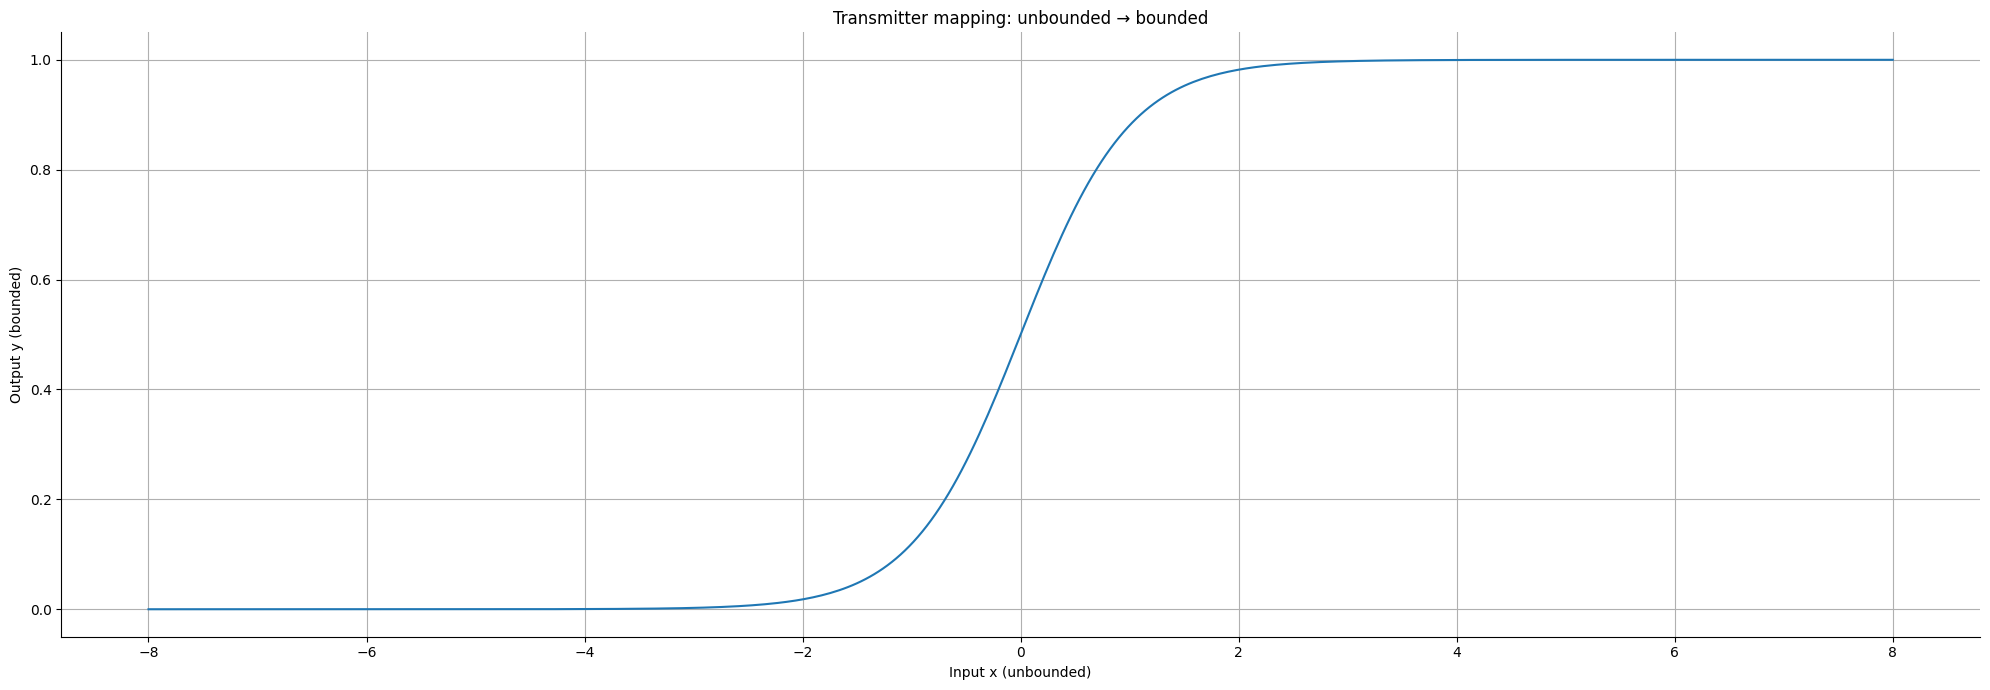

In [4]:
def visualize_transmitter(
    transmitter: Transmitter,
    x_min: float = -8.0,
    x_max: float = 8.0,
    n_points: int = 400,
) -> None:
    """Plot the transformation applied by a Transmitter on a single bounded dimension."""
    x = np.linspace(x_min, x_max, n_points)
    y = np.array([transmitter.process_forward(np.array([xi]))[0] for xi in x])
    
    plt.figure()
    plt.plot(x, y)
    plt.title("Transmitter mapping: unbounded → bounded")
    plt.xlabel("Input x (unbounded)")
    plt.ylabel("Output y (bounded)")
    plt.tight_layout()
    plt.show()
    return


visualize_transmitter(t_full)


### Observations

- The mapping is smooth and strictly monotonic.
- As `x → -∞`, the output asymptotically approaches the lower bound `min_x`.
- As `x → +∞`, the output asymptotically approaches the upper bound `max_x`.
- Values near `x = 0` are mapped close to the midpoint of `[min_x, max_x]`.
- This behavior is the natural inverse of the Receiver’s artanh-based mapping.

## 3. Mixed bounds and multi-dimensional behavior

Realistic environments often have a mix of bounded, unbounded, and partially bounded dimensions.

Here we explore:

- How Transmitter treats each dimension type.
- How batches of internal signals are mapped into external space.
- Per-dimension visualization of the mapping.

In [5]:
# Generate a small batch of example internal signals for the mixed Transmitter
X_mixed = np.array([
    [-5.0,   -3.0,   -5.0,   0.0],   # large negative on bounded dim 0
    [-1.0,   -1.0,    0.0,   2.5],   # moderate values
    [ 0.0,    0.0,    5.0,   5.0],   # near center / upper ranges
    [ 5.0,    1.5,   10.0,   4.9],   # large positive on bounded dim 0
], dtype=float)

Y_mixed = np.array([t_mixed.process_forward(x) for x in X_mixed])

print(f"Internal batch (X_mixed):\n{X_mixed}")
print(f"\nExternal batch (Y_mixed):\n{Y_mixed}")
print(f"\nhas_bounds: {t_mixed.has_bounds}")

Internal batch (X_mixed):
[[-5.  -3.  -5.   0. ]
 [-1.  -1.   0.   2.5]
 [ 0.   0.   5.   5. ]
 [ 5.   1.5 10.   4.9]]

External batch (Y_mixed):
[[ 4.53978687e-05 -3.00000000e+00 -5.00000000e+00  0.00000000e+00]
 [ 1.19202922e-01 -1.00000000e+00  0.00000000e+00  2.50000000e+00]
 [ 5.00000000e-01  0.00000000e+00  5.00000000e+00  5.00000000e+00]
 [ 9.99954602e-01  1.50000000e+00  1.00000000e+01  4.90000000e+00]]

has_bounds: [ True False False False]


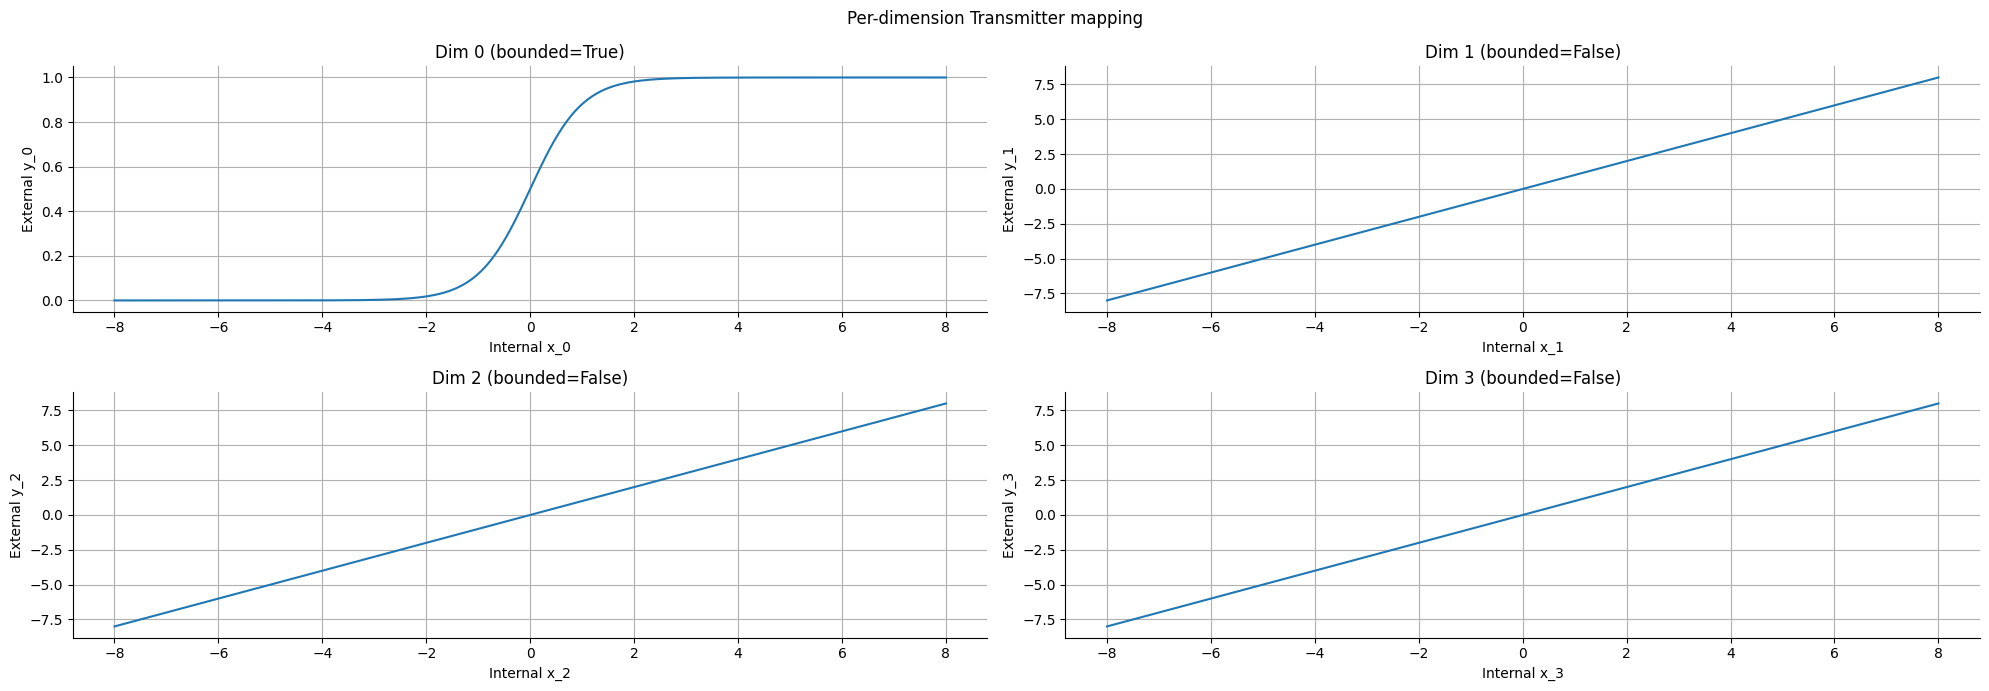

In [6]:
def visualize_multidim_transmitter(
    transmitter: Transmitter,
    n_points: int = 400
) -> None:
    """For each dimension of the Transmitter, plot how x_i is transformed into y_i."""
    N = transmitter.N
    n_cols = min(N, 2)
    n_rows = int(np.ceil(N / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, squeeze=False)

    for i in range(N):
        ax = axes[i // n_cols][i % n_cols]

        # Use a generic range for visualization in internal space
        x_min, x_max = -8.0, 8.0
        x = np.linspace(x_min, x_max, n_points)

        # Build full internal vectors: vary only dim i, keep others at 0
        X = np.zeros((n_points, N), dtype=float)
        X[:, i] = x

        y = np.array([transmitter.process_forward(row)[i] for row in X])

        ax.plot(x, y)
        ax.set_title(f"Dim {i} (bounded={transmitter.has_bounds[i]})")
        ax.set_xlabel(f"Internal x_{i}")
        ax.set_ylabel(f"External y_{i}")

    fig.suptitle("Per-dimension Transmitter mapping")
    plt.tight_layout()
    plt.show()
    return


visualize_multidim_transmitter(t_mixed)

### Observations

- Fully bounded dimensions show the characteristic S-shaped squashing between `min_x[i]` and `max_x[i]`.
- Dimensions without both finite bounds (`has_bounds[i] == False`) are effectively passed through unchanged.
- This allows Transmitter to handle heterogeneous action spaces in a simple, composable way.

## 4. Edge cases and numerical behavior

The Transmitter relies on `tanh`, which is numerically stable and saturates smoothly for large-magnitude inputs.

In this section we probe:

- Extremely large positive and negative internal values.
- Behavior of partially bounded dimensions (which should pass through).

In [7]:
def probe_extreme_values(
    transmitter: Transmitter,
    magnitudes: tuple[float] = (0.0, 1.0, 5.0, 8.0, 10.0, 50.0, 100.0)
) -> None:
    """Test how the Transmitter behaves with extreme internal values."""
    print("=== Extreme value probe ===")
    for mag in magnitudes:
        print()
        for sign in (-1.0, 1.0):
            x_val = sign * mag
            y_val = transmitter.process_forward(np.array([x_val]))[0]
            print(f"x={x_val:8.1f} -> y={y_val:.6f}")
    return


probe_extreme_values(t_full)

=== Extreme value probe ===

x=    -0.0 -> y=0.500000
x=     0.0 -> y=0.500000

x=    -1.0 -> y=0.119203
x=     1.0 -> y=0.880797

x=    -5.0 -> y=0.000045
x=     5.0 -> y=0.999955

x=    -8.0 -> y=0.000000
x=     8.0 -> y=1.000000

x=   -10.0 -> y=0.000000
x=    10.0 -> y=1.000000

x=   -50.0 -> y=0.000000
x=    50.0 -> y=1.000000

x=  -100.0 -> y=0.000000
x=   100.0 -> y=1.000000


## 5. Dynamic dimensionality (`add_dimension` / `remove_dimension`)

The Transmitter supports dynamic changes in its dimensionality:

- `add_dimension` appends a new dimension with optional bounds.
- `remove_dimension` deletes a dimension and its associated bounds.

This is useful when the external environment changes (e.g. new actuators are introduced or some outputs become obsolete).

In this section we demonstrate how the internal configuration evolves as dimensions are added and removed.

In [8]:
# Start from a simple 2D Transmitter
t_dyn = Transmitter(
    size=2,
    min_x=[0.0, np.nan],
    max_x=[1.0, np.nan],
)

print("=== Initial Transmitter (2D) ===")
print(f"N: {t_dyn.N}")
print(f"min_x: {t_dyn.min_x}")
print(f"max_x: {t_dyn.max_x}")
print(f"has_bounds: {t_dyn.has_bounds}")

# Add a new fully bounded dimension
t_dyn.add_dimension(min_x=-5.0, max_x=5.0)

print("\n=== After add_dimension (3D) ===")
print(f"N: {t_dyn.N}")
print(f"min_x: {t_dyn.min_x}")
print(f"max_x: {t_dyn.max_x}")
print(f"has_bounds: {t_dyn.has_bounds}")

# Remove the middle dimension (index 1)
t_dyn.remove_dimension(idx=1)

print("\n=== After remove_dimension(idx=1) (back to 2D) ===")
print(f"N: {t_dyn.N}")
print(f"min_x: {t_dyn.min_x}")
print(f"max_x: {t_dyn.max_x}")
print(f"has_bounds: {t_dyn.has_bounds}")

=== Initial Transmitter (2D) ===
N: 2
min_x: [ 0. nan]
max_x: [ 1. nan]
has_bounds: [ True False]

=== After add_dimension (3D) ===
N: 3
min_x: [ 0. nan -5.]
max_x: [ 1. nan  5.]
has_bounds: [ True False  True]

=== After remove_dimension(idx=1) (back to 2D) ===
N: 2
min_x: [ 0. -5.]
max_x: [1. 5.]
has_bounds: [ True  True]


Snapshot: before adding a bounded second dimension


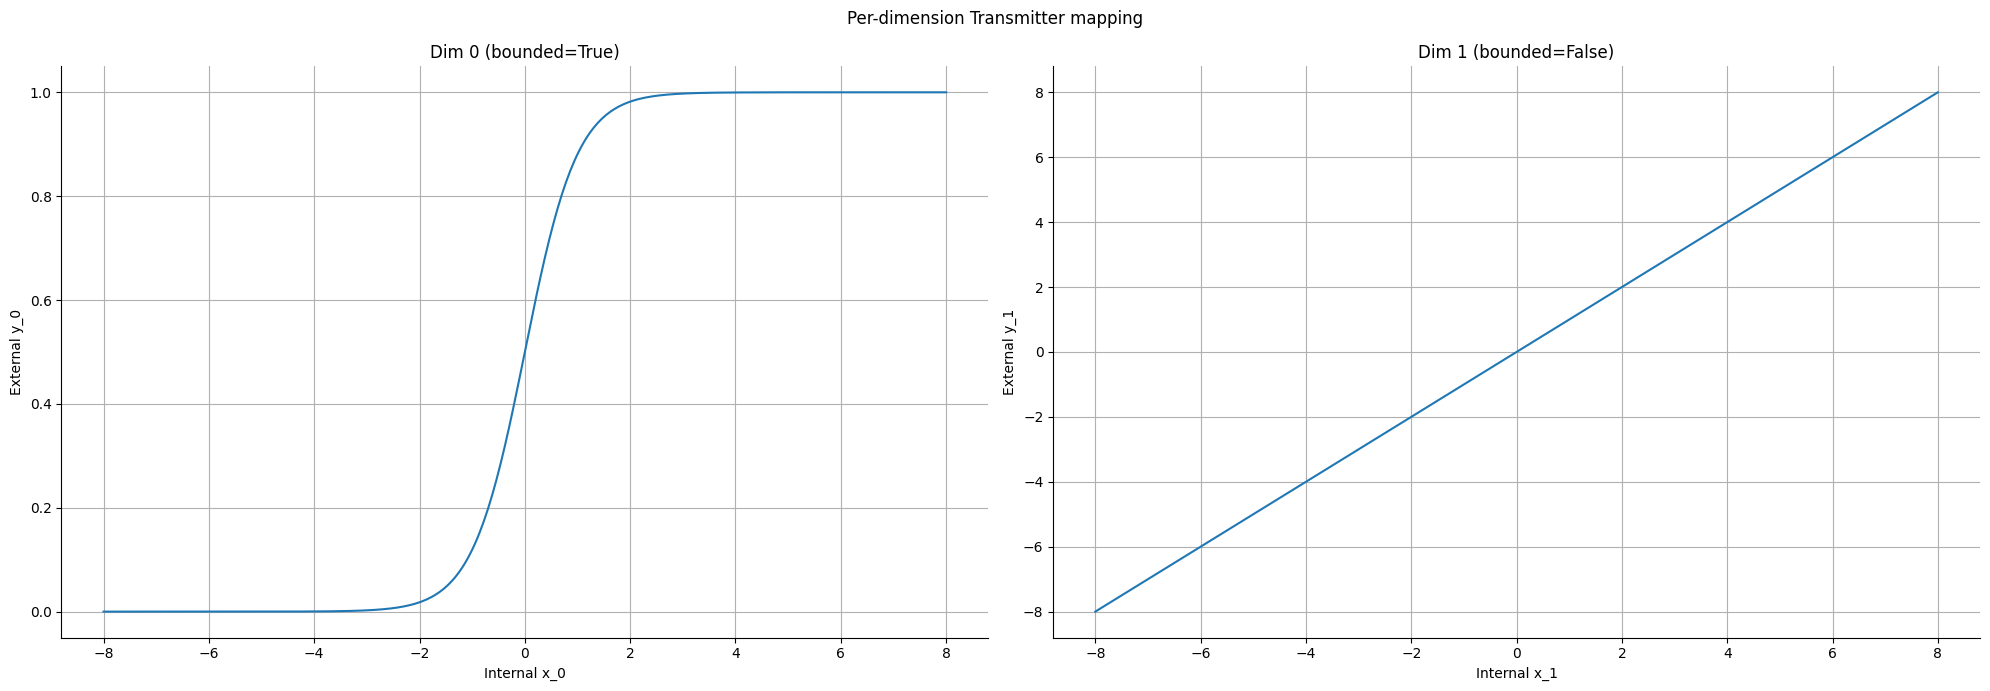

Snapshot: after adding a bounded second dimension


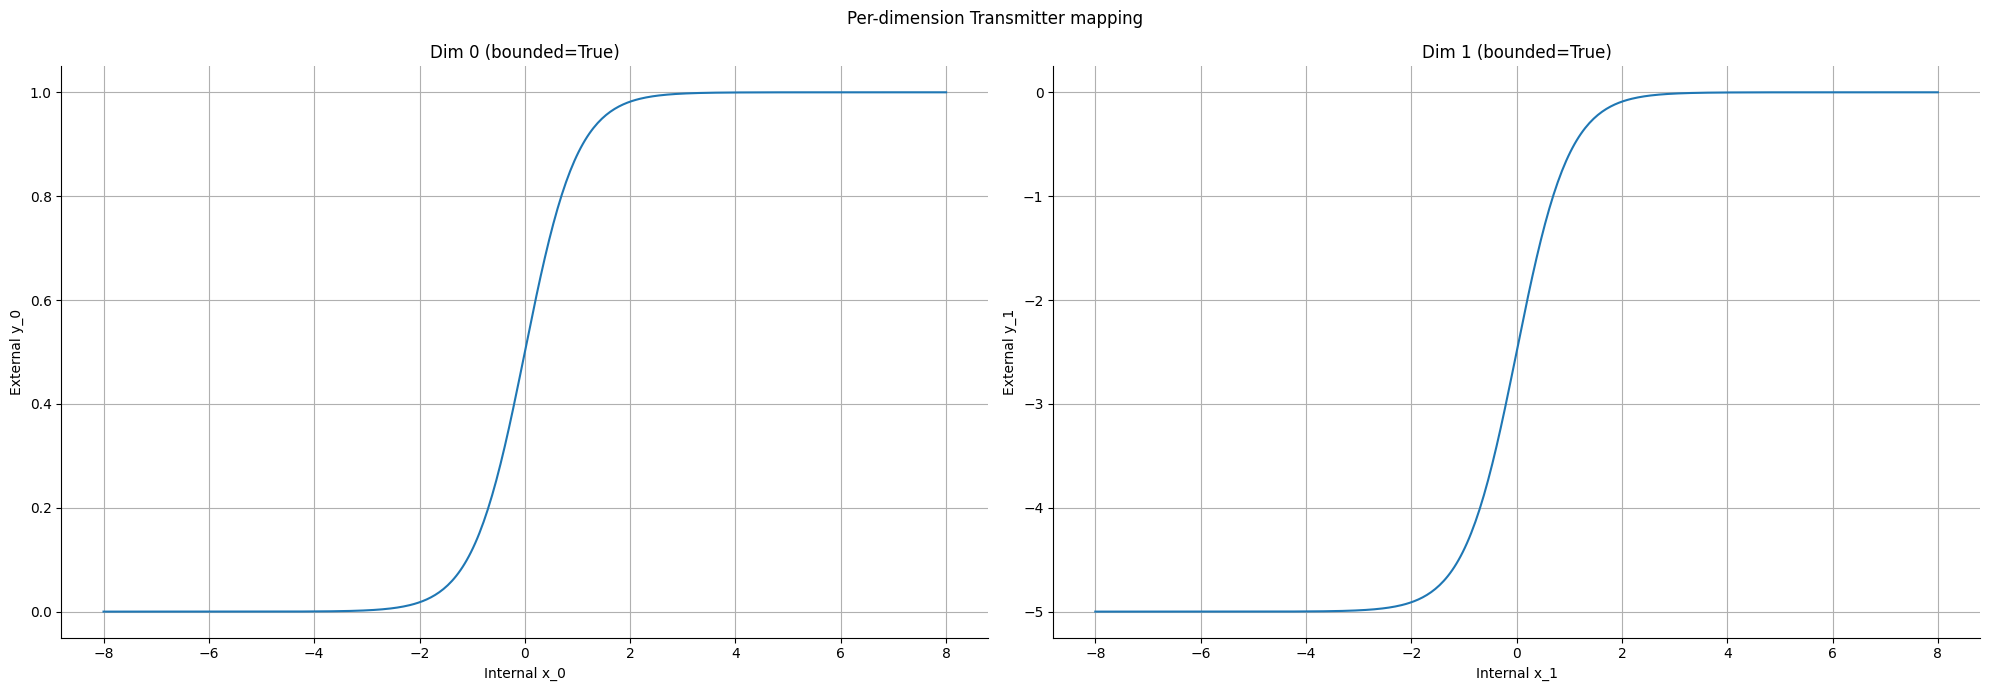

In [9]:
# Visualize the mapping for the dynamic Transmitter before and after modifications

# Reconstruct two snapshots for clarity
t_before = Transmitter(
    size=2,
    min_x=[0.0, np.nan],
    max_x=[1.0, np.nan],
)

t_after = Transmitter(
    size=2,
    min_x=[0.0, -5.0],
    max_x=[1.0,  0.0],
)

print("Snapshot: before adding a bounded second dimension")
visualize_multidim_transmitter(t_before)

print("Snapshot: after adding a bounded second dimension")
visualize_multidim_transmitter(t_after)

## 6. Serialization and reconstruction

For reproducibility and deployment, it is useful to serialize Transmitter configurations as JSON-friendly dictionaries.

In this section we:

- Convert a configured Transmitter instance into a dictionary.
- Reconstruct a fresh instance from that dictionary.
- Verify that core fields match exactly.

Although the class also provides file-based `save()` and `load()` methods, this section focuses on the in-memory approach to avoid creating temporary files.

In [10]:
# Create a Transmitter with mixed bounds
t_serial = Transmitter(
    size=3,
    min_x=[0.0, -1.0, np.nan],
    max_x=[1.0,  1.0,  np.nan],
)

# Convert to dictionary
t_dict = t_serial.to_dict()

# Reconstruct a new Transmitter from that dictionary
t_clone = Transmitter.from_dict(t_dict)

# Verify that both have identical configurations
print("\n=== Comparison check ===")
print("\nOriginal min_x:", t_serial.min_x)
print("Restored min_x:", t_clone.min_x)
print("\nOriginal max_x:", t_serial.max_x)
print("Restored max_x:", t_clone.max_x)
print("\nOriginal has_bounds:", t_serial.has_bounds)
print("Restored has_bounds:", t_clone.has_bounds)


=== Comparison check ===

Original min_x: [ 0. -1. nan]
Restored min_x: [ 0. -1. nan]

Original max_x: [ 1.  1. nan]
Restored max_x: [ 1.  1. nan]

Original has_bounds: [ True  True False]
Restored has_bounds: [ True  True False]


### Observations

- The `to_dict()` method produces a JSON-friendly snapshot containing `size`, `min_x`, `max_x`, and `has_bounds`.
- `from_dict()` can fully reconstruct the Transmitter’s configuration without any loss of information.
- The pair `save(path)` / `load(path)` are simple wrappers around these two methods that persist the same information to disk.

## 7. Summary

In this notebook we have explored the Transmitter module — Jacinta’s output interface for external actions — and demonstrated:

- How bounded and unbounded dimensions are handled differently.
- The shape of the tanh-based mapping from `ℝ → [min, max]`.
- Saturation behavior for large-magnitude internal signals.
- Mixed-dimensional behavior with selective transformation.
- Dynamic dimensionality through `add_dimension()` and `remove_dimension()`.
- In-memory serialization with `to_dict()` / `from_dict()`.

The Transmitter provides a smooth, invertible bridge from Jacinta’s internal continuous domain back to the constrained, often bounded space of real-world actions. It ensures that learned internal policies can be safely and consistently turned into valid external commands.